In [1]:
#Importing libraries: 
from PIL import Image
import random, os
import torch
import torch.nn as nn
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import sys
sys.path.append('/')

#requriements
#pip install efficientnet_pytorch
#conda install -c conda-forge opencv

import cv2
import numpy as np
from efficientnet_pytorch import EfficientNet
from grad_cam import GradCam,GuidedBackpropReLUModel,show_cams,show_gbs,preprocess_image

In [581]:
#Load the model
model = EfficientNet.from_name('efficientnet-b1')
for params in model.parameters():
    params.requires_grad = True

In [582]:
#Add extra steps for last layer and correct number of classes (=1):
in_ftrs = model._fc.in_features
model._fc = nn.Linear(in_ftrs, 1)


In [583]:
#To load the best model:
loaded_model = model
loaded_model.load_state_dict(torch.load('1000images_200_clusters.pt'))

<All keys matched successfully>

In [584]:
grad_cam = GradCam(model=loaded_model, blob_name = '_blocks', target_layer_names=['10','13','14','15','20','21','22'], use_cuda=False)
img = cv2.imread('/assets/demo_raw', 1)
img = np.float32(cv2.resize(img, (224, 224))) / 255
inputs = preprocess_image(img)

In [585]:
target_index = None #281 for cat #dog 245 or 242 one is bulldog and more accurate
mask_dic = grad_cam(inputs, target_index)
show_cams(img, mask_dic)
gb_model = GuidedBackpropReLUModel(model=model, activation_layer_name = 'MemoryEfficientSwish', use_cuda=False)
show_gbs(inputs, gb_model, target_index, mask_dic)

## Generate masks for all tiles in folder:

In [595]:
source_dir = '/MediaEvalMedico_21TestDataset/images'
image_files = os.listdir(source_dir)

In [596]:
mask_dic_list = []
for _image in image_files:
    #Load the model
    model = EfficientNet.from_name('efficientnet-b1')
    for params in model.parameters():
        params.requires_grad = True
    #Add extra steps for last layer and correct number of classes (=1):
    in_ftrs = model._fc.in_features
    model._fc = nn.Linear(in_ftrs, 1)
    loaded_model = model
    loaded_model.load_state_dict(torch.load('tile_1000images_50clusters.pt'))
    
    #Generate gradcam:
    image_path = os.path.join(source_dir, _image)
    #Extract heat map from layer 14:
    grad_cam = GradCam(model=loaded_model, blob_name = '_blocks', target_layer_names=['14'], use_cuda=False)
    img = cv2.imread(image_path, 1)
    img = np.float32(cv2.resize(img, (224, 224))) / 255
    inputs = preprocess_image(img)
    #Set target as polyp
    target_index = None 
    mask_dic = grad_cam(inputs, target_index)
    mask_dic_list.append(mask_dic)

In [597]:
#For model with 50 or 200 clusters (narrow threshold):
segmentation_dic_list = []
for _dic in mask_dic_list:
    new_dic = _dic['14'].copy()
    for _l in range(len(_dic['14'])):
        for _p in range(len(_dic['14'][_l])):
            if _dic['14'][_l][_p] > 0.4 and _dic['14'][_l][_p] < 0.7:
                new_dic[_l][_p] = 1
            else:
                new_dic[_l][_p] = 0
    new_dic = {'14':new_dic}
    segmentation_dic_list.append(new_dic)

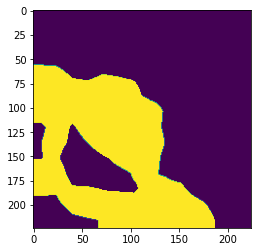

In [592]:
pl.imshow(segmentation_dic_list[0]['14'])

In [594]:
image_files[0][:-4]

'1f39a761-ff59-44a1-b4f9-0b10becf29cf'

## Save the segmentation masks in a folder

In [598]:
for s in range(len(segmentation_dic_list)):
    fig = pl.imshow(segmentation_dic_list[s]['14'])
    #Remove axis:
    pl.axis('off')
    save_path = '50clusters_layer14_masks_testdata/' + image_files[s][:-4] + '.png'
    #Remove white spaces using pad_inches
    pl.savefig(save_path, bbox_inches = 'tight', pad_inches = 0)
    pl.close()

# Resize the images to original size and write to new folder as .png:

In [626]:
small_masks_dir = '50clusters_layer14_masks_testdata'
small_mask_files = os.listdir(small_masks_dir)
small_mask_files.remove('.DS_Store')
large_masks_dir = 'Run1'

In [627]:
len(small_mask_files)

200

In [628]:
from PIL import Image
for _mask in range(len(small_mask_files)):
    img = Image.open(small_masks_dir + '/' + small_mask_files[_mask])
    #print(source_dir + '/' + small_mask_files[_mask])
    orig_image = cv2.imread(source_dir + '/' + small_mask_files[_mask][:-4] + '.jpg', 1)
    height, width, channels = orig_image.shape
    img = img.resize((width,height), Image.ANTIALIAS)
    img = img.save(large_masks_dir + '/' + small_mask_files[_mask][:-4] + '.png')
    

/Users/andreastoras/Downloads/MediaEvalMedico_21TestDataset/images/1f39a761-ff59-44a1-b4f9-0b10becf29cf.jpg
/Users/andreastoras/Downloads/MediaEvalMedico_21TestDataset/images/ed5fb1f6-732d-4a6a-a5a2-c88fee2ef1cd.jpg
/Users/andreastoras/Downloads/MediaEvalMedico_21TestDataset/images/2c3887a0-88e6-43df-8fb6-61f34ecae93f.jpg
/Users/andreastoras/Downloads/MediaEvalMedico_21TestDataset/images/0edc6d1b-f23b-48aa-adea-4610f2f8bceb.jpg
/Users/andreastoras/Downloads/MediaEvalMedico_21TestDataset/images/ea95b1da-a74a-46f9-a56a-e07335c5e2dd.jpg
/Users/andreastoras/Downloads/MediaEvalMedico_21TestDataset/images/02a47ca5-8c9e-4a25-af7c-0829d3bb6d11.jpg
/Users/andreastoras/Downloads/MediaEvalMedico_21TestDataset/images/f1af53f4-91bb-4d68-9833-f4b9b95e406c.jpg
/Users/andreastoras/Downloads/MediaEvalMedico_21TestDataset/images/2cb0abd5-0558-4be2-a4ac-7c6da2686099.jpg
/Users/andreastoras/Downloads/MediaEvalMedico_21TestDataset/images/2d0a5406-3781-43e9-bed7-14a0f62cc19a.jpg
/Users/andreastoras/Download

/Users/andreastoras/Downloads/MediaEvalMedico_21TestDataset/images/e8930c78-fbb3-4359-ac10-a2efe733e814.jpg
/Users/andreastoras/Downloads/MediaEvalMedico_21TestDataset/images/0bb2e271-f2ec-41eb-844f-b9ed824823e3.jpg
/Users/andreastoras/Downloads/MediaEvalMedico_21TestDataset/images/e2336dc9-dd44-4bc3-8d66-8a05d9c626f8.jpg
/Users/andreastoras/Downloads/MediaEvalMedico_21TestDataset/images/0b51fc05-a393-4d93-a96b-dc339ffc55d6.jpg
/Users/andreastoras/Downloads/MediaEvalMedico_21TestDataset/images/e66314ae-8b6e-445d-9f53-c42ae012ce55.jpg
/Users/andreastoras/Downloads/MediaEvalMedico_21TestDataset/images/ef1cca98-e98d-4ab8-8412-a8e9656cb7ef.jpg
/Users/andreastoras/Downloads/MediaEvalMedico_21TestDataset/images/ef4fb2e2-fecc-4b46-b874-9ee885023147.jpg
/Users/andreastoras/Downloads/MediaEvalMedico_21TestDataset/images/3d9b8807-c49a-49ba-8ef6-5371dddf8905.jpg
/Users/andreastoras/Downloads/MediaEvalMedico_21TestDataset/images/e8762fa3-13d0-46bc-b7ec-2437c7080ff4.jpg
/Users/andreastoras/Download

/Users/andreastoras/Downloads/MediaEvalMedico_21TestDataset/images/2d6b7de1-bce7-4353-a86e-5eb4dd880723.jpg
/Users/andreastoras/Downloads/MediaEvalMedico_21TestDataset/images/2a9ef80d-1af8-4f0a-ba11-b00790a79815.jpg
/Users/andreastoras/Downloads/MediaEvalMedico_21TestDataset/images/eec3528f-feaa-457e-aa9d-26f44f722a3e.jpg
/Users/andreastoras/Downloads/MediaEvalMedico_21TestDataset/images/eaf13300-f5ed-40be-8f92-b3fa2487c65c.jpg
/Users/andreastoras/Downloads/MediaEvalMedico_21TestDataset/images/ed5c8b65-7160-4e0b-8a40-1f02772bb67b.jpg
/Users/andreastoras/Downloads/MediaEvalMedico_21TestDataset/images/ea559daa-3995-4fd3-bba9-ac26cf59b098.jpg
/Users/andreastoras/Downloads/MediaEvalMedico_21TestDataset/images/2a7f994b-fb68-4f16-af00-e3a3871a6dce.jpg
/Users/andreastoras/Downloads/MediaEvalMedico_21TestDataset/images/ef17501e-22c0-4001-8553-b6cdaf804162.jpg
/Users/andreastoras/Downloads/MediaEvalMedico_21TestDataset/images/0b063da6-d842-41c1-bd33-a6118401429d.jpg
/Users/andreastoras/Download